ToDo 

[] reduce size of finetuning dataset 

[] see how performance changes as a function of the % of the finetuning dataset used

[x] create an end2end baseline 

[] change to 1 layer 

[x] update early stopping

[] investigate SGD

[] other stuff on slack 

[] randomsearch with wandb

In [38]:
import sys
sys.path.append('..')

from utils import *
from data_utils import *
from metrics import *
from plots import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from types import SimpleNamespace

## Testing dataset generation 

ADAM IS THE KEY 

In [39]:
def compute_training_acc_epochs(model, dataset, params, debug=False, save_checkpoints=False, plot_boundary=False):
    device = torch.device(params['device'])
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])   

    best_model_state = None  # To save the best model weights/state
    if params['early_stop_patience']:
        no_improve_epochs = 0
        max_val_acc = 0.

    train_acc = 0.0
    model.train()
    checkpoints = []
    effective_epochs = 0

    # Loop over epochs
    for epoch in range(params['num_train']):
        effective_epochs += 1
        for batch_idx, (data, target) in enumerate(dataset.train_loader):
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Evaluate after each epoch
        if debug:
            train_acc = eval(model, device, dataset.train_loader, debug=False)
            val_acc = eval(model, device, dataset.val_loader, debug=False)
            print('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))
            print('Validation Accuracy: {:.2f}%'.format(val_acc*100))

        if params['early_stop_patience']:
            if val_acc > max_val_acc:
                max_val_acc = val_acc
                best_model_state = model.state_dict().copy() # This line saves the best model state.
                no_improve_epochs = 0
                best_model_state = model.state_dict()  # Save the best model state
            else:
                no_improve_epochs += 1
                print("val_acc: {}, max_val_acc: {}, no_improve_epochs: {}".format(val_acc, max_val_acc, no_improve_epochs))
                if no_improve_epochs >= params['early_stop_patience']:
                    print("Early stopping invoked.")
                    if best_model_state is not None:
                        model.load_state_dict(best_model_state)  # Load the best model weights
                    break
        
        if save_checkpoints:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_acc': train_acc,
                'val_acc': val_acc
            }
            torch.save(checkpoint, 'checkpoint_epoch_{}.pth'.format(epoch))
            checkpoints.append(checkpoint)

    # At the end of training, load the best weights if early stopping wasn't invoked 
    # (in case the final epochs did not improve performance)
    if params['early_stop_patience']:
        if not params['early_stop_patience'] or no_improve_epochs < params['early_stop_patience']:
            model.load_state_dict(best_model_state)

    train_acc = eval(model, device, dataset.train_loader, debug=False)
    test_acc = eval(model, device, dataset.test_loader, debug=False)

    if save_checkpoints:
        return train_acc, test_acc, model, checkpoints, effective_epochs
    else:
        return train_acc, test_acc, model, [], effective_epochs


In [40]:
def compute_training_acc_epochs_cnn(model, dataset, params, debug=False, logger=print):
    device = torch.device(params['device'])
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])
    
    best_model_state = None  # To save the best model weights/state
    if params.get('early_stop_patience', None):
        no_improve_epochs = 0
        max_val_acc = 0.

    if debug: 
        logger(model, optimizer)

    train_acc = 0.0
    model.train()

    effective_epochs = 0  # Initialize effective_epochs counter

    # Loop over epochs
    for epoch in range(params['num_train']):
        effective_epochs += 1  # Increment counter for each epoch
        for batch_idx, (data, target) in enumerate(dataset.train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            if debug and batch_idx % 20 == 0:
                pass

        # Evaluate after each epoch
        if debug:
            train_acc = eval_cnn(model, device, dataset.train_loader, debug=False)
            val_acc = eval_cnn(model, device, dataset.val_loader, debug=False)
            logger('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))
            logger('Validation Accuracy: {:.2f}%'.format(val_acc*100))

        if params.get('early_stop_patience', None):
            if val_acc > max_val_acc:
                max_val_acc = val_acc
                best_model_state = model.state_dict().copy() 
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1
                logger("val_acc: {}, max_val_acc: {}, no_improve_epochs: {}".format(val_acc, max_val_acc, no_improve_epochs))
                if no_improve_epochs >= params['early_stop_patience']:
                    logger("Early stopping invoked.")
                    if best_model_state is not None:
                        model.load_state_dict(best_model_state)  # Load the best model weights
                    break

    # At the end of training, load the best weights if early stopping wasn't invoked 
    if params.get('early_stop_patience', None):
        if not params['early_stop_patience'] or no_improve_epochs < params['early_stop_patience']:
            model.load_state_dict(best_model_state)

    train_acc = eval_cnn(model, device, dataset.train_loader, debug=False)
    test_acc = eval_cnn(model, device, dataset.test_loader, debug=False)
    return train_acc, test_acc, model,[], effective_epochs


In [41]:
import torch.utils.data as data

def reduce_dataset(dataloader, percentage, seed=42):
    """
    Reduces the dataset to the given percentage.

    Parameters:
    - dataloader: PyTorch DataLoader object.
    - percentage: Desired percentage of the original dataset.
    - seed: Seed for reproducibility.

    Returns:
    - reduced_dataloader: DataLoader with the reduced dataset.
    """
    # Extract the dataset from the dataloader
    dataset = dataloader.dataset
    
    # Extract all data and labels from the dataset
    X = [dataset[i][0] for i in range(len(dataset))]
    y = [dataset[i][1] for i in range(len(dataset))]

    # Set the seed for reproducibility
    torch.manual_seed(seed)

    # Determine the number of samples to keep
    num_samples = int(len(dataset) * percentage)
    
    # Randomly select indices without replacement
    indices = torch.randperm(len(dataset))[:num_samples]

    # Use a Subset of the original dataset to create a reduced dataset
    reduced_dataset = data.Subset(dataset, indices)

    # Create a DataLoader with the reduced dataset. 
    # You may want to copy other settings from the original DataLoader (like batch_size).
    reduced_dataloader = data.DataLoader(reduced_dataset, batch_size=dataloader.batch_size, shuffle=True)

    return reduced_dataloader

import torch
from torch.utils import data

def reduce_dataset_balanced(dataloader, percentage, seed=42):
    """
    Reduces the dataset to the given percentage ensuring class balance.

    Parameters:
    - dataloader: PyTorch DataLoader object.
    - percentage: Desired percentage of the original dataset.
    - seed: Seed for reproducibility.

    Returns:
    - reduced_dataloader: DataLoader with the reduced dataset.
    """
    # Extract the dataset from the dataloader
    dataset = dataloader.dataset
    
    # Extract all data and labels from the dataset
    X = [dataset[i][0] for i in range(len(dataset))]
    y = [dataset[i][1] for i in range(len(dataset))]

    # Set the seed for reproducibility
    torch.manual_seed(seed)

    # Get unique classes and their counts
    classes, class_counts = torch.unique(torch.tensor(y), return_counts=True)
    
    # Determine the number of samples per class to keep
    num_samples_per_class = int(len(dataset) * percentage / len(classes))
    selected_indices = []

    for class_label in classes:
        class_indices = [i for i, label in enumerate(y) if label == class_label]
        
        # Randomly select indices without replacement for each class
        class_selected_indices = torch.randperm(len(class_indices))[:num_samples_per_class].tolist()
        selected_indices.extend([class_indices[i] for i in class_selected_indices])

    # Use a Subset of the original dataset to create a reduced dataset
    reduced_dataset = data.Subset(dataset, selected_indices)

    # Create a DataLoader with the reduced dataset. 
    # You may want to copy other settings from the original DataLoader (like batch_size).
    reduced_dataloader = data.DataLoader(reduced_dataset, batch_size=dataloader.batch_size, shuffle=True)

    return reduced_dataloader



## Pretraining

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [43]:
batch_size = 128
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

dataset = TransferLearningMNIST(batch_size)
dataset_wrapped = TransferLearningMNISTWrapper(dataset, 'pretrain')

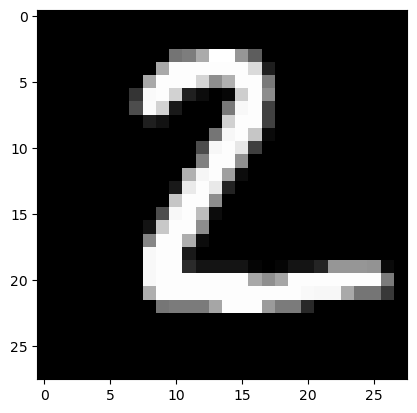

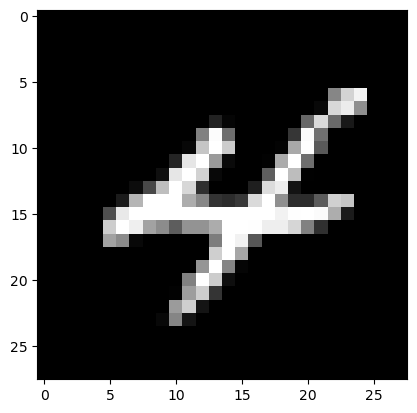

-------------


In [44]:
a = dataset_wrapped.test_loader
b = dataset_wrapped.train_loader

#check if the content of the two loaders are the same, and print the respective mnist images, use zip 
for i, (data_a, data_b) in enumerate(zip(a, b)):
        plt.imshow(data_a[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        plt.imshow(data_b[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        print('-------------')
        break

In [62]:
device = 'mps'

depth = 3

params = dict(device=device,
                width=2, lr=0.01, num_train=10,
                sb=0.05, depth= depth, sw=1.7346938775510203, early_stop_patience = 4, activation_function='ReLU')

# Create DNN model
model = generate_cnn(28, 10,
                params['depth'], params['width'], act_fn=nn.ReLU, use_pooling=False).to(device)

# Train and evaluate
train_acc, test_acc, model, _, effective_epochs = compute_training_acc_epochs_cnn(model, dataset_wrapped, params, debug=True)

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")


CustomCNN(
  (conv0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (fc): Linear(in_features=1568, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
) SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Epoch: 0 	Training Accuracy: 20.27%
Validation Accuracy: 19.90%
Epoch: 1 	Training Accuracy: 89.11%
Validation Accuracy: 88.74%
Epoch: 2 	Training Accuracy: 91.39%
Validation Accuracy: 90.54%
Epoch: 3 	Training Accuracy: 93.10%
Validation Accuracy: 91.97%
Epoch: 4 	Training Accuracy: 93.96%
Validation Accuracy: 93.10%
Epoch: 5 	Training Accuracy: 94.40%
Validation Accuracy: 93.61%
Epoch: 6 	Training Accuracy: 93.82%
Validation Accuracy:

In [63]:
print(model)

CustomCNN(
  (conv0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (fc): Linear(in_features=1568, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)


In [64]:
eval_cnn(model, device, dataset_wrapped.test_loader, debug=True)


Train set: Average loss: 0.1665, Accuracy: 4621.0/4861 (95%)



0.9506274429129808

conv0.weight: 4.4136
conv1.weight: 9.2169
conv2.weight: 7.7953
fc.weight: 9.5357


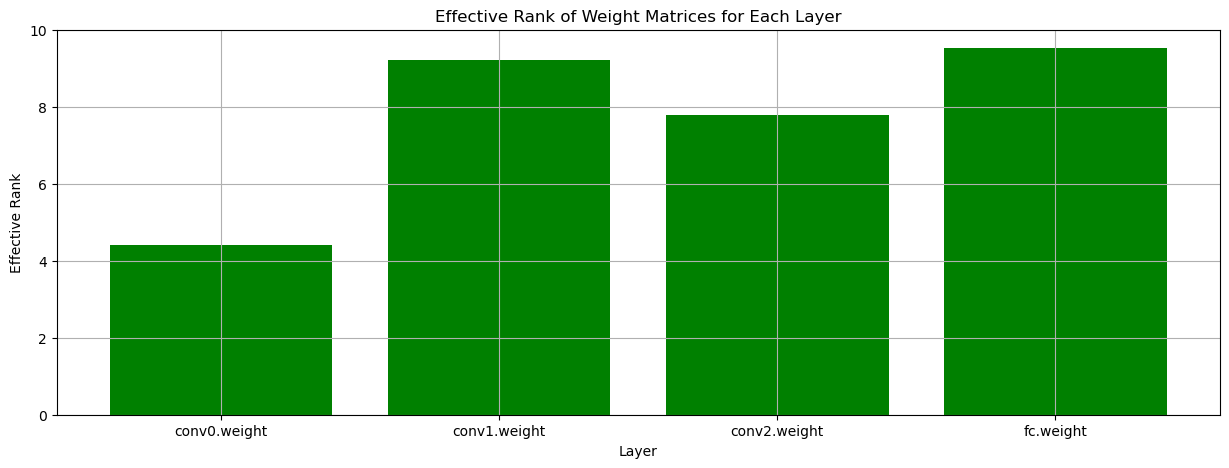

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import torch

'''def effective_rank(singular_values):
    sigma_max = np.max(singular_values)
    sigma_min = singular_values[-1] if singular_values[-1] > 0 else np.min(singular_values[singular_values > 0])
    # print(sigma_max, sigma_min)
    print(np.sqrt(sigma_max / sigma_min))
    print('----')
    return np.sqrt(sigma_max / sigma_min)'''

def effective_rank(singular_values):
    normalized_singular_values = singular_values / np.sum(singular_values)
    entropy = -np.sum(normalized_singular_values * np.log(normalized_singular_values))
    eff_rank = np.exp(entropy)
    return eff_rank

def plot_layer_effective_ranks(model, print_ranks=True):
    effective_ranks = []
    layer_names = []
    
    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            singular_values = np.linalg.svd(weight_matrix, compute_uv=False)
            eff_rank = effective_rank(singular_values)
            effective_ranks.append(eff_rank)
            layer_names.append(name)

    if print_ranks:
        for layer_name, eff_rank in zip(layer_names, effective_ranks):
            print(f'{layer_name}: {eff_rank:.4f}')
    
    # Plotting
    plt.figure(figsize=(15, 5))
    plt.bar(layer_names, effective_ranks, color='green')
    plt.xlabel('Layer')
    plt.ylabel('Effective Rank')
    plt.title('Effective Rank of Weight Matrices for Each Layer')
    plt.grid(True)
    
    y_max = np.max(effective_ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(effective_ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(0, int(y_max)+2, step=2))  # Set yticks

    plt.show()

# Example usage
plot_layer_effective_ranks(model)  # Note: You'll need to define or load 'model' before calling this function


----

# Finetuning experiments

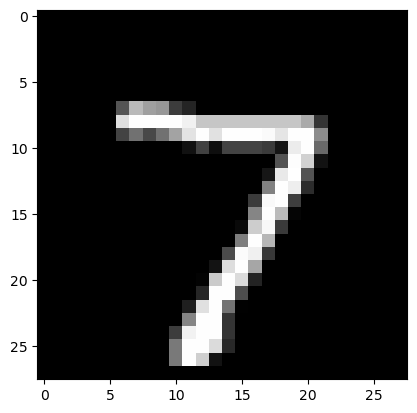

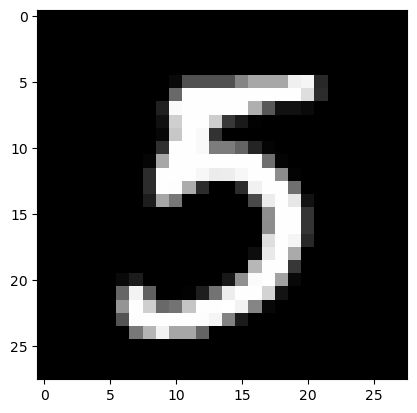

-------------


In [81]:
dataset_wrapped.update_phase('finetune')

a = dataset_wrapped.test_loader
b = dataset_wrapped.train_loader

#check if the content of the two loaders are the same, and print the respective mnist images, use zip 
for i, (data_a, data_b) in enumerate(zip(a, b)):
        plt.imshow(data_a[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        plt.imshow(data_b[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        print('-------------')
        break


## Baseline model: end2end with the same architecture as the preatining model

In [67]:
# 2. Create a new model and copy weights from the original model, then adjust the final layer
model_finetuning_baseline = generate_cnn(28, 10,
                params['depth'], params['width'], act_fn=nn.ReLU, use_pooling=False).to(device)

dataset_wrapped.update_phase('finetune')
# Train and evaluate the new model on the new data
train_acc_new, test_acc_new, model_finetuning_baseline, _,_ = compute_training_acc_epochs_cnn(model_finetuning_baseline, dataset_wrapped, params, debug=True)

print(f"Final Training Accuracy (New Data): {train_acc_new:.4f}")
print(f"Final Test Accuracy (New Data): {test_acc_new:.4f}")

CustomCNN(
  (conv0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (fc): Linear(in_features=1568, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
) SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


Epoch: 0 	Training Accuracy: 20.03%
Validation Accuracy: 18.71%
Epoch: 1 	Training Accuracy: 21.20%
Validation Accuracy: 22.28%
Epoch: 2 	Training Accuracy: 39.09%
Validation Accuracy: 38.95%
Epoch: 3 	Training Accuracy: 87.27%
Validation Accuracy: 86.77%
Epoch: 4 	Training Accuracy: 93.04%
Validation Accuracy: 92.79%
Epoch: 5 	Training Accuracy: 93.33%
Validation Accuracy: 92.69%
val_acc: 0.9268707482993197, max_val_acc: 0.927891156462585, no_improve_epochs: 1
Epoch: 6 	Training Accuracy: 94.00%
Validation Accuracy: 93.81%
Epoch: 7 	Training Accuracy: 94.12%
Validation Accuracy: 93.98%
Epoch: 8 	Training Accuracy: 93.88%
Validation Accuracy: 93.47%
val_acc: 0.9346938775510204, max_val_acc: 0.939795918367347, no_improve_epochs: 1
Epoch: 9 	Training Accuracy: 94.14%
Validation Accuracy: 93.74%
val_acc: 0.9374149659863945, max_val_acc: 0.939795918367347, no_improve_epochs: 2
Final Training Accuracy (New Data): 0.9414
Final Test Accuracy (New Data): 0.9383


conv0.weight: 4.5617
conv1.weight: 8.2260
conv2.weight: 8.4890
fc.weight: 9.7413


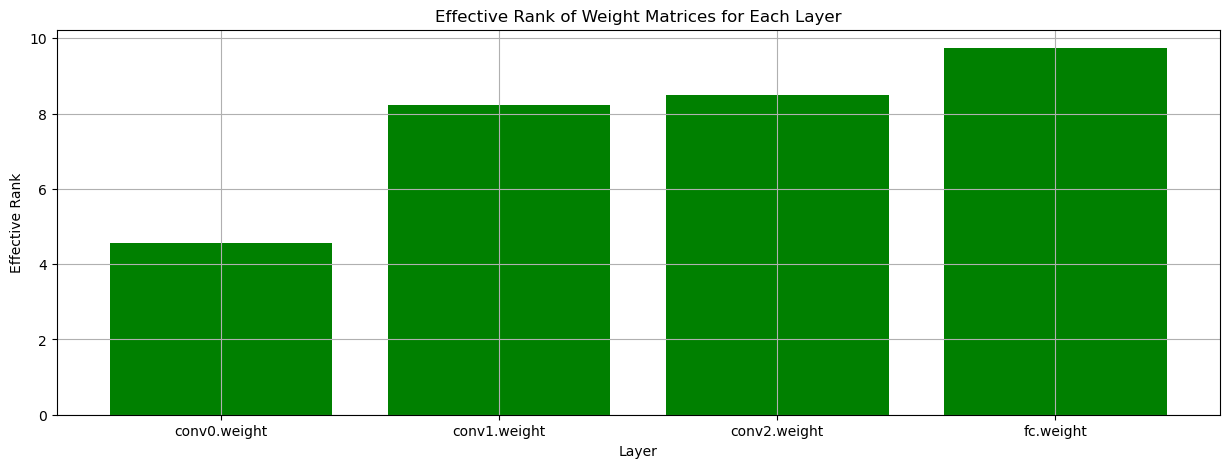

In [68]:
#eval(model, device, dataset_wrapped.test_loader, debug=True, classification_report_flag = True)
plot_layer_effective_ranks(model_finetuning_baseline)
# results, variances = compute_layer_variances_dense(model_finetuning_baseline, test_loader_transfer, device = 'cpu',cnn=False)
# plot_variances_by_layer_type(variances, results, cnn = False, ignore_final_layer=True, std_of_variance = True )

now with balanced classes

Percentage: 0.01
Repeat: 0, with seed 33 =========================
CustomCNN(
  (conv0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (fc): Linear(in_features=1568, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
) SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Epoch: 0 	Training Accuracy: 20.00%
Validation Accuracy: 18.71%
Epoch: 1 	Training Accuracy: 20.00%
Validation Accuracy: 18.71%
val_acc: 0.1870748299319728, max_val_acc: 0.1870748299319728, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 20.00%
Validation Accuracy: 18.71%
val_acc: 0.1870748299319728, max_val_acc: 0.1870748299319728, no_improve_epochs: 2
Epoch: 3 	Train

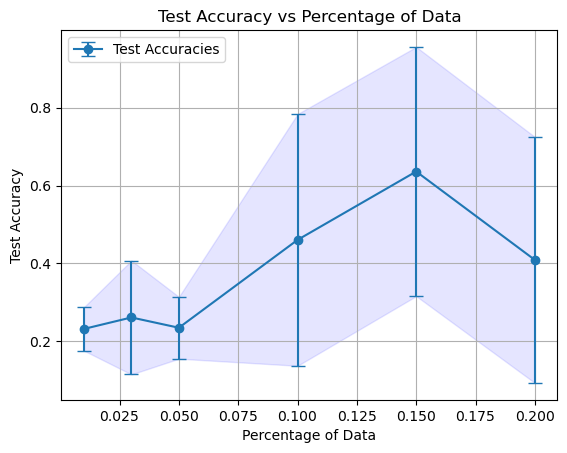

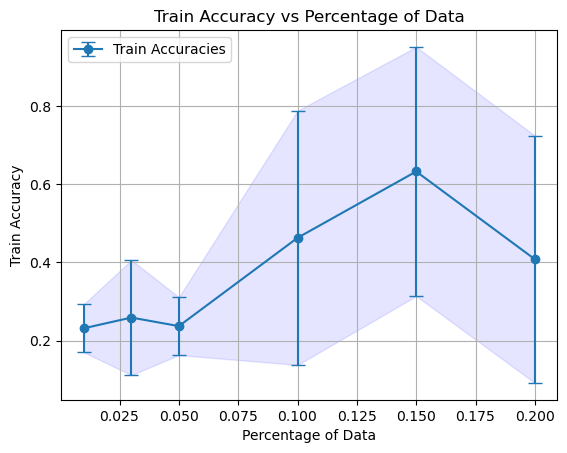

In [69]:
import numpy as np
import matplotlib.pyplot as plt

dataset_wrapped.update_phase('finetune')

#percentages = np.linspace(0.1, 1.0, 10)  # from 10% to 100%
percentages = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2]
seed_set = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
repeats = 3

params['lr'] = 0.01    
params['num_train'] = 10
params['early_stop_patience'] = 4

# Store results for each percentage
results_test = {}
results_train = {}
best_models = {}
data_loaders = {}
epochs_taken = {}  # Dictionary to store the number of epochs for each (perc, seed) tuple

for perc in percentages:
    print(f"Percentage: {perc}")
    test_accuracies = []
    train_accuracies = []
    epochs_for_this_percentage = []  # Store epochs for this percentage

    for _, temp_seed in enumerate(seed_set):
        #temp_seed as a random seed 
        temp_seed  = random.randint(0, 100)
        print(f"Repeat: {_}, with seed {temp_seed} =========================")
        model_new =  generate_cnn(28, 10,
                params['depth'], params['width'], act_fn=nn.ReLU, use_pooling=False).to(device)
        
        # Reduce datasets
        train_loader_transfer_reduced = reduce_dataset_balanced(dataset_wrapped.train_loader, perc, seed=temp_seed)
        if _ == 0:
            data_loaders[perc] = train_loader_transfer_reduced
        test_loader_transfer_reduced = dataset_wrapped.test_loader
        val_loader_transfer_reduced = dataset_wrapped.val_loader
        
        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_transfer_reduced, test_loader=test_loader_transfer_reduced, val_loader=val_loader_transfer_reduced)
        
        train_acc_new, test_acc_new, _, _, num_epochs = compute_training_acc_epochs_cnn(model_new, dataset_namespace_new, params, debug=True)
        
        test_accuracies.append(test_acc_new)
        train_accuracies.append(train_acc_new)
        epochs_for_this_percentage.append(num_epochs)

        print('eval on reduced train set')
        eval_cnn(model_new, device, train_loader_transfer_reduced, debug=True)
        print('eval on full test set')
        eval_cnn(model_new, device, test_loader_transfer_reduced, debug=True)

        # Uncomment this block if you need the best model per percentage logic
        # if train_acc_new > best_accuracy:
        #     best_accuracy = train_acc_new
        #     best_models[perc] = model_new.state_dict()  # Save only the model's parameters (state_dict)
        
    results_test[perc] = test_accuracies
    results_train[perc] = train_accuracies
    epochs_taken[perc] = epochs_for_this_percentage

# Now, you can print or store the number of epochs for each (percentage, seed) tuple:
for perc in percentages:
    for seed, epoch_num in zip(seed_set, epochs_taken[perc]):
        print(f"Percentage: {perc}, Seed: {seed}, Epochs taken: {epoch_num}")


# Save the best models
# for perc in best_models:
#     torch.save(best_models[perc], f"best_model_{int(perc*100)}_percent.pth")

# Plot the results
means = [np.mean(results_test[perc]) for perc in percentages]
stds = [np.std(results_test[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Test Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

#plot the training accuracies
means = [np.mean(results_train[perc]) for perc in percentages]
stds = [np.std(results_train[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Train Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()


## Only heads and data for new classes

now with balanced classes

In [70]:
#length of train_loader_transfer_reduced
print(len(train_loader_transfer_reduced.dataset))
len(dataset_wrapped.train_loader.dataset)

5290


26464

Percentage: 0.01
Repeat: 0, with seed 47 =========================


CustomCNN(
  (conv0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (fc): Linear(in_features=1568, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
) SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Epoch: 0 	Training Accuracy: 96.92%
Validation Accuracy: 94.05%
Epoch: 1 	Training Accuracy: 96.92%
Validation Accuracy: 93.88%
val_acc: 0.9387755102040817, max_val_acc: 0.9404761904761905, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 89.62%
Validation Accuracy: 89.32%
val_acc: 0.8931972789115646, max_val_acc: 0.9404761904761905, no_improve_epochs: 2
Epoch: 3 	Training Accuracy: 97.69%
Validation Accuracy: 93.71%
val_acc: 0.9370748

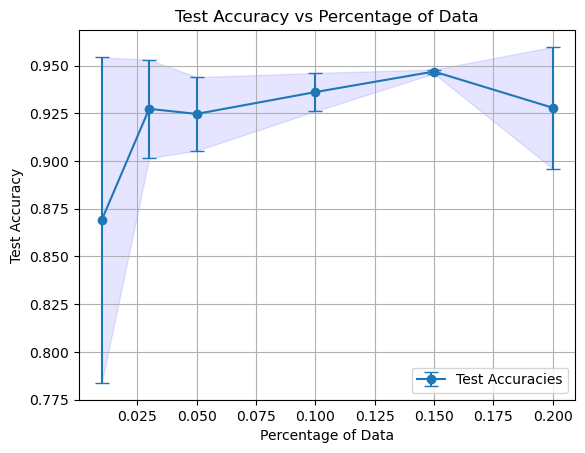

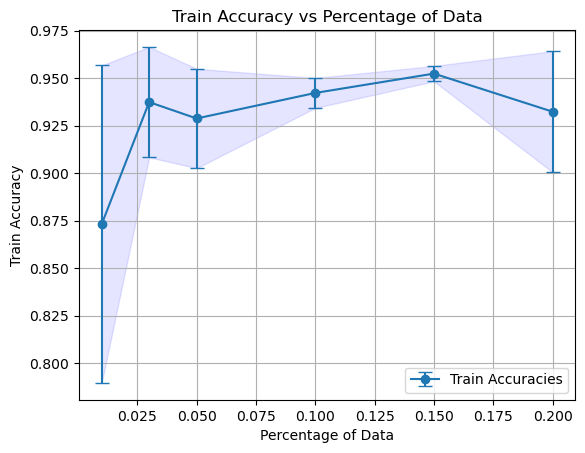

In [71]:
import numpy as np
import matplotlib.pyplot as plt

dataset_wrapped.update_phase('finetune')

percentages = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2]
seed_set = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
repeats = 3

params['lr'] = 0.01  
params['num_train'] = 10
params['early_stop_patience'] = 4

# Store results for each percentage
results_test_finetune = {}
results_train_finetune = {}
best_models = {}
data_loaders = {}
epochs_taken_finetune = {}  # Dictionary to store the number of epochs for each (perc, seed) tuple

for perc in percentages:
    print(f"Percentage: {perc}")
    test_accuracies = []
    train_accuracies = []
    epochs_for_this_percentage = []  # Store epochs for this percentage

    for _, temp_seed in enumerate(seed_set):
        #temp_seed as a random seed 
        temp_seed  = random.randint(0, 100)
        print(f"Repeat: {_}, with seed {temp_seed} =========================")

        ''' model_new = generate_fc_dnn(dataset.input_dim, 10, params, gaussian_init=False, activation_function = nn.ReLU)

        # Copy weights
        for name, param in model.named_parameters():
            if "linear" + str(depth) not in name:
                model_new._parameters[name] = param'''
    
        model_new = copy.deepcopy(model)

        #freeze them 
        # for name, param in model.named_parameters():
        #     if "linear" + str(depth-1) not in name:
        #         param.requires_grad = False
        
        # Reduce datasets
        train_loader_transfer_reduced = reduce_dataset_balanced(dataset_wrapped.train_loader, perc, seed=temp_seed)
        if _ == 0:
            data_loaders[perc] = train_loader_transfer_reduced
        test_loader_transfer_reduced = dataset_wrapped.test_loader
        val_loader_transfer_reduced = dataset_wrapped.val_loader
        
        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_transfer_reduced, test_loader=test_loader_transfer_reduced, val_loader=val_loader_transfer_reduced)
        
        train_acc_new, test_acc_new, _, _, num_epochs = compute_training_acc_epochs_cnn(model_new, dataset_namespace_new, params, debug=True)
        
        test_accuracies.append(test_acc_new)
        train_accuracies.append(train_acc_new)
        epochs_for_this_percentage.append(num_epochs)

        print('eval on reduced train set')
        eval_cnn(model_new, device, train_loader_transfer_reduced, debug=True)
        print('eval on full test set')
        eval_cnn(model_new, device, test_loader_transfer_reduced, debug=True)

        # Uncomment this block if you need the best model per percentage logic
        # if train_acc_new > best_accuracy:
        #     best_accuracy = train_acc_new
        #     best_models[perc] = model_new.state_dict()  # Save only the model's parameters (state_dict)
        
    results_test_finetune[perc] = test_accuracies
    results_train_finetune[perc] = train_accuracies
    epochs_taken_finetune[perc] = epochs_for_this_percentage

# Now, you can print or store the number of epochs for each (percentage, seed) tuple:
for perc in percentages:
    for seed, epoch_num in zip(seed_set, epochs_taken_finetune[perc]):
        print(f"Percentage: {perc}, Seed: {seed}, Epochs taken: {epoch_num}")


# Save the best models
# for perc in best_models:
#     torch.save(best_models[perc], f"best_model_{int(perc*100)}_percent.pth")

# Plot the results
means = [np.mean(results_test_finetune[perc]) for perc in percentages]
stds = [np.std(results_test_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Test Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

#plot the training accuracies
means = [np.mean(results_train_finetune[perc]) for perc in percentages]
stds = [np.std(results_train_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Train Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()


In [72]:
print(model_new)

CustomCNN(
  (conv0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (fc): Linear(in_features=1568, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)


In [73]:
for name, param in model.named_parameters():
    if "linear" + str(depth-1) not in name:
        #model_new._parameters[name] = param
        print('layer name: ', name)
        


layer name:  conv0.weight
layer name:  conv0.bias
layer name:  conv1.weight
layer name:  conv1.bias
layer name:  conv2.weight
layer name:  conv2.bias
layer name:  fc.weight
layer name:  fc.bias


In [74]:
print(f'end to end {epochs_taken}')
print(f'finetune {epochs_taken_finetune}')

end to end {0.01: [5, 10, 6, 5, 10, 7, 6, 5, 7, 10], 0.03: [10, 10, 8, 10, 10, 5, 5, 10, 6, 10], 0.05: [9, 5, 5, 5, 10, 9, 5, 10, 5, 8], 0.1: [10, 5, 10, 10, 5, 5, 10, 9, 8, 10], 0.15: [10, 5, 5, 10, 10, 10, 10, 10, 10, 10], 0.2: [10, 6, 10, 5, 5, 5, 6, 6, 10, 5]}
finetune {0.01: [5, 10, 5, 7, 10, 7, 10, 5, 10, 6], 0.03: [10, 9, 7, 10, 8, 10, 6, 10, 5, 8], 0.05: [5, 10, 10, 5, 6, 6, 7, 7, 5, 5], 0.1: [10, 7, 5, 6, 8, 8, 10, 5, 6, 10], 0.15: [9, 6, 9, 9, 10, 6, 5, 10, 9, 7], 0.2: [5, 6, 10, 6, 9, 9, 9, 10, 5, 7]}


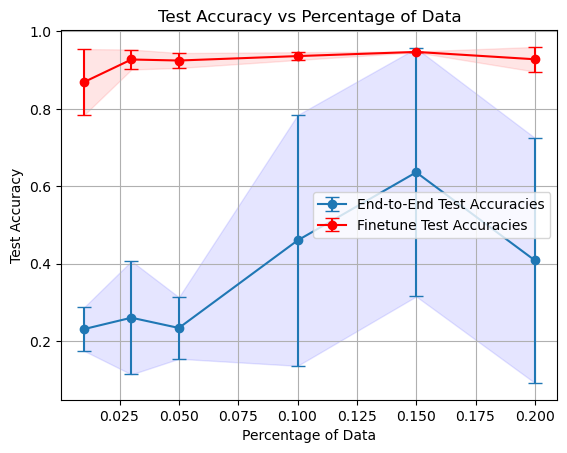

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# End to End - Test Accuracies
means = [np.mean(results_test[perc]) for perc in percentages]
stds = [np.std(results_test[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="End-to-End Test Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

# Finetune - Test Accuracies
means = [np.mean(results_test_finetune[perc]) for perc in percentages]
stds = [np.std(results_test_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Finetune Test Accuracies", color='r')
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='r', alpha=0.1)

# Displaying the Test Accuracies plot
plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()


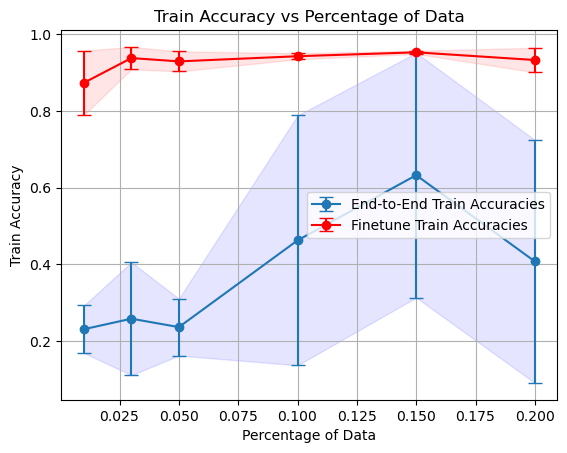

In [76]:
# End to End - Train Accuracies
means = [np.mean(results_train[perc]) for perc in percentages]
stds = [np.std(results_train[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="End-to-End Train Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

# Finetune - Train Accuracies
means = [np.mean(results_train_finetune[perc]) for perc in percentages]
stds = [np.std(results_train_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Finetune Train Accuracies", color='r')
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='r', alpha=0.1)

# Displaying the Train Accuracies plot
plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()


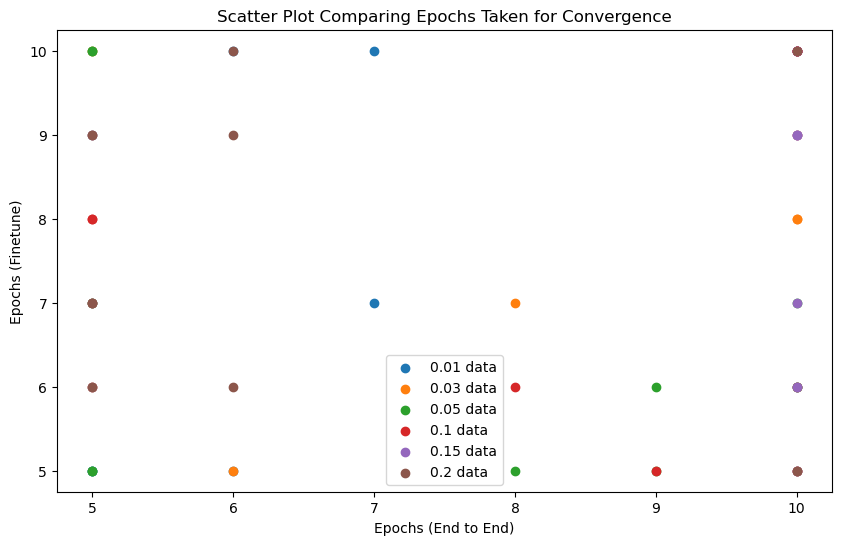

In [77]:
plt.figure(figsize=(10, 6))
for perc in percentages:
    plt.scatter(epochs_taken[perc], epochs_taken_finetune[perc], label=f'{perc} data')
plt.xlabel('Epochs (End to End)')
plt.ylabel('Epochs (Finetune)')
plt.title('Scatter Plot Comparing Epochs Taken for Convergence')
plt.legend()
plt.show()


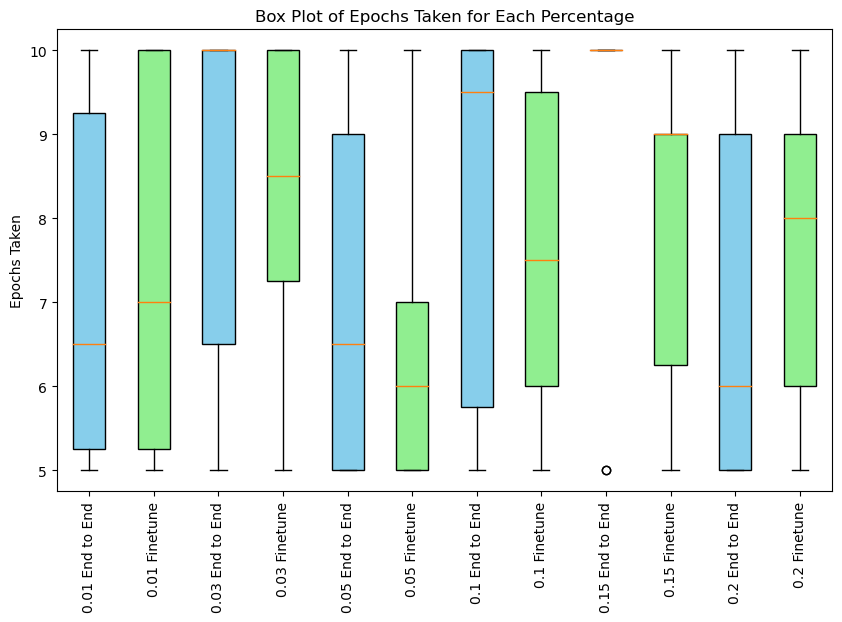

In [78]:
import matplotlib.pyplot as plt

# Given data
percentages = list(epochs_taken.keys())

all_epochs = []
labels = []

for perc in percentages:
    all_epochs.extend([epochs_taken[perc], epochs_taken_finetune[perc]])
    labels.extend([f'{perc} End to End', f'{perc} Finetune'])

# Plotting
plt.figure(figsize=(10, 6))
box = plt.boxplot(all_epochs, labels=labels, patch_artist=True)

# Coloring
colors = ['skyblue', 'lightgreen'] * len(percentages)
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('Epochs Taken')
plt.title('Box Plot of Epochs Taken for Each Percentage')
plt.xticks(rotation=90)
plt.show()
